# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [ ]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Create a custom leaky relu as an aux function
    def relu_leaky(f, alpha=0.2):
        return tf.maximum(f, alpha * f)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # First layer, conv layer with shape as the images, using custom leaky ReLU with alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        x1 = relu_leaky(x1)
        
        # Two more layers with batch normalization
        x2 = tf.layers.conv2d(x1, 128, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = relu_leaky(x2)
        
        x3 = tf.layers.conv2d(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = relu_leaky(x3)

        # Calculate the logits and outputs by flattening and dense
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Create a custom leaky relu as an aux function, it would be better
    # to do it only once if not in notebook
    def relu_leaky(f, alpha=0.2):
        return tf.maximum(f, alpha * f)
    
    # We only reuse if we don't train, so we use that
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First layers to start generating convs from random noise
        # layer -> batch norm -> activation
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = relu_leaky(x1)
        # Shape now is 4x4x512
        
        # Next layers, transpose convolution, need to get to 7 square, so valid padding
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = relu_leaky(x2)
        # Shape now is 7x7x256
        
        # Next layer, regular transpose convolution, as in lessons
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = relu_leaky(x3)
        # Shape now 14x14x128
        
        # Get the generated image
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Implement function as in lesson, most of it the same
    # Generate the fake images
    g_model = generator(input_z, out_channel_dim)
    # Evaluate the real images 
    d_model_real, d_logits_real = discriminator(input_real)
    # Evaluate the fake images 
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Losses
    smooth = 0.1
    # Calculate the real loss to teach the discriminator they are real
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * (1 - smooth)))
    # Calculate the fake loss to teach the discriminator they are fake
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_model_fake)))
    # Calculate the loss of the generator to teach it to be like the real thing
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real+ d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Similar to lessons
    # Weights and bias to be updated, get all variables and assign them to generator and discriminator vars
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # And optimize each part
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    im_width, im_height, im_channels = data_shape[1:]
    
    # tf.reset_default_graph() # Just in case that something from MNIST affects faces
    real_input, z_input, l_rate = model_inputs(im_width, im_width, im_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, im_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                
                # Print every 10 steps
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, im_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6805... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 0.4008... Generator Loss: 3.3601
Epoch 1/2... Discriminator Loss: 0.5181... Generator Loss: 1.9164
Epoch 1/2... Discriminator Loss: 0.5001... Generator Loss: 4.0759
Epoch 1/2... Discriminator Loss: 0.4412... Generator Loss: 4.8029
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.2390
Epoch 1/2... Discriminator Loss: 0.8585... Generator Loss: 7.7851
Epoch 1/2... Discriminator Loss: 0.4099... Generator Loss: 6.9590
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.7288
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 2.0461


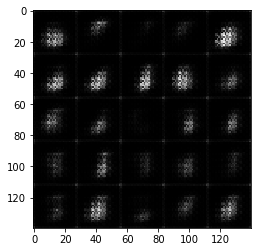

Epoch 1/2... Discriminator Loss: 0.4595... Generator Loss: 3.9114
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 1.6764
Epoch 1/2... Discriminator Loss: 0.4976... Generator Loss: 3.1098
Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 3.5185
Epoch 1/2... Discriminator Loss: 0.5740... Generator Loss: 2.5556
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.2684
Epoch 1/2... Discriminator Loss: 0.6490... Generator Loss: 1.9764
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 0.6841... Generator Loss: 2.1065
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 2.0266


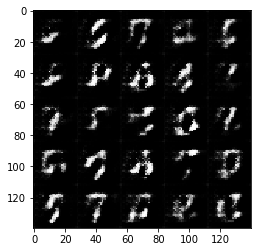

Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.6237
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 1.4513
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 2.4122
Epoch 1/2... Discriminator Loss: 0.9119... Generator Loss: 1.6121
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 0.7891... Generator Loss: 2.1069
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 1.9745
Epoch 1/2... Discriminator Loss: 0.8593... Generator Loss: 2.3599
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 1.6084
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.2139


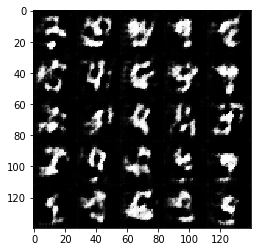

Epoch 1/2... Discriminator Loss: 0.8036... Generator Loss: 1.5769
Epoch 1/2... Discriminator Loss: 0.7885... Generator Loss: 1.3677
Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 1.7438
Epoch 1/2... Discriminator Loss: 0.9095... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 0.7684... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 0.7646... Generator Loss: 1.3799
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 1.5797
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.9634
Epoch 1/2... Discriminator Loss: 1.1850... Generator Loss: 1.0890


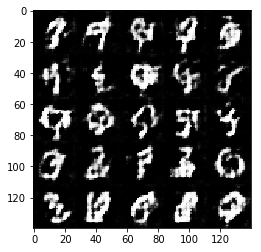

Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.4353
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.8631
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 1.5900
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 1.7686
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 1.9150
Epoch 1/2... Discriminator Loss: 1.0880... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 1.5176... Generator Loss: 0.5246


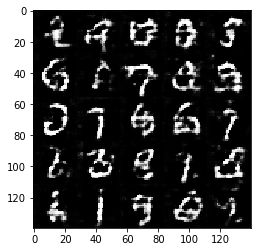

Epoch 1/2... Discriminator Loss: 0.8664... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 1.1064... Generator Loss: 1.2038
Epoch 1/2... Discriminator Loss: 0.9707... Generator Loss: 1.8173
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.5979
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.3245
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 1.9305
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 1.7151... Generator Loss: 0.3679
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 0.9843


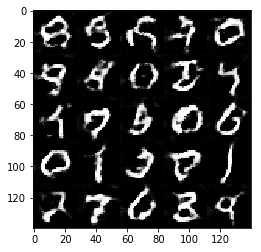

Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.1870... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.8945
Epoch 1/2... Discriminator Loss: 0.9527... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 1.0377... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 1.1755
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.2099
Epoch 1/2... Discriminator Loss: 1.0685... Generator Loss: 1.7707
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.1245


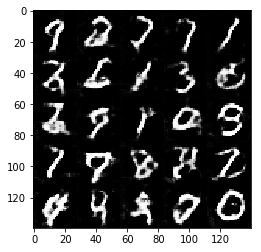

Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.3899
Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 1.0878... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 0.9704... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 1.9497
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.4040... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 1.4090
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 1.0236... Generator Loss: 0.9930


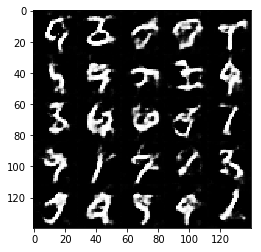

Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 1.2469
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 0.9364... Generator Loss: 1.1507
Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 0.9972... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 2.6353
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.4345
Epoch 1/2... Discriminator Loss: 0.9014... Generator Loss: 1.0955


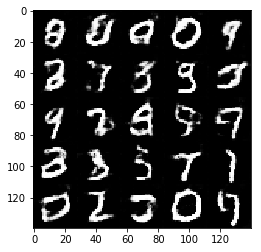

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.7869... Generator Loss: 0.3376
Epoch 1/2... Discriminator Loss: 1.0475... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.8482
Epoch 2/2... Discriminator Loss: 0.8828... Generator Loss: 1.4593
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 2.5818
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 1.2851
Epoch 2/2... Discriminator Loss: 0.8895... Generator Loss: 1.4624
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.5584


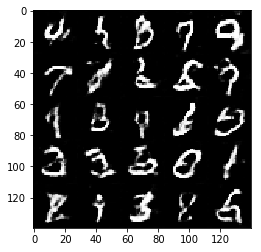

Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.7758... Generator Loss: 1.4949
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.6247
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.2481
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.6157


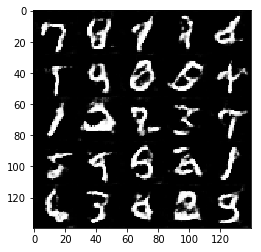

Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.5021
Epoch 2/2... Discriminator Loss: 0.9281... Generator Loss: 1.0548
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.3024
Epoch 2/2... Discriminator Loss: 1.1448... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 2.1190
Epoch 2/2... Discriminator Loss: 0.8845... Generator Loss: 1.0864
Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.7517
Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.1146
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 1.2244


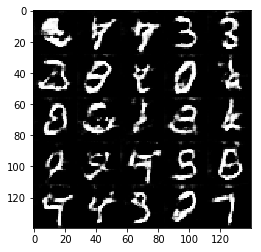

Epoch 2/2... Discriminator Loss: 0.7591... Generator Loss: 1.2603
Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.2674
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.2460
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 2.5981
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 0.9615
Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.0853
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.7648
Epoch 2/2... Discriminator Loss: 2.4242... Generator Loss: 3.4143


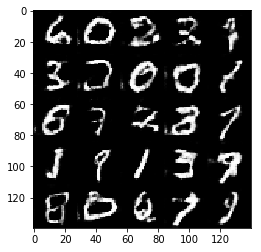

Epoch 2/2... Discriminator Loss: 1.1088... Generator Loss: 0.7686
Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.5463
Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.3579
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 2.3156
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.7948
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 1.9629
Epoch 2/2... Discriminator Loss: 1.5617... Generator Loss: 2.5049
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.8351


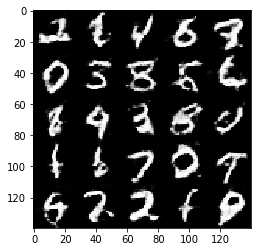

Epoch 2/2... Discriminator Loss: 1.2168... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.0581... Generator Loss: 2.2841
Epoch 2/2... Discriminator Loss: 0.7927... Generator Loss: 1.4217
Epoch 2/2... Discriminator Loss: 0.7509... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.8297... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.6922... Generator Loss: 1.5396
Epoch 2/2... Discriminator Loss: 1.1239... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 0.9814... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.6876
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.8205


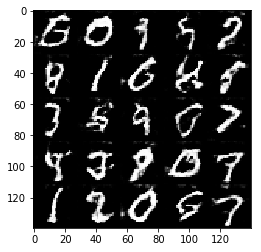

Epoch 2/2... Discriminator Loss: 1.8149... Generator Loss: 2.9068
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 0.9917... Generator Loss: 0.8668
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 0.7402... Generator Loss: 1.3374
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.6018
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.1344... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.4565
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.1567


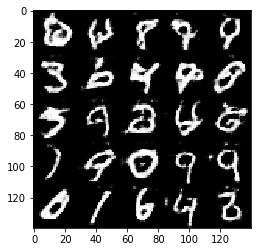

Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.1091
Epoch 2/2... Discriminator Loss: 0.6840... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.9510
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.5366
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.0251
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 0.7269... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 1.3434... Generator Loss: 0.5690
Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 2.5467


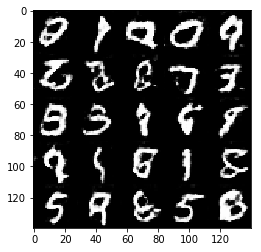

Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.5720
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 1.5784
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.1557
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 0.6124... Generator Loss: 2.3181
Epoch 2/2... Discriminator Loss: 0.5692... Generator Loss: 1.8635
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.7486
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 0.7992


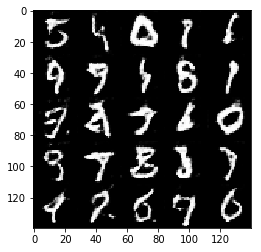

Epoch 2/2... Discriminator Loss: 0.6323... Generator Loss: 1.5373
Epoch 2/2... Discriminator Loss: 1.8270... Generator Loss: 0.3597
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 3.2507
Epoch 2/2... Discriminator Loss: 0.7392... Generator Loss: 1.4973
Epoch 2/2... Discriminator Loss: 1.6341... Generator Loss: 0.3962
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 1.3686
Epoch 2/2... Discriminator Loss: 2.0860... Generator Loss: 0.2919


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
mnist_dataset.shape

Epoch 1/1... Discriminator Loss: 2.4945... Generator Loss: 0.1973
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.3952
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.9372
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 0.6733... Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.5981


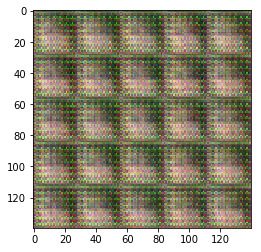

Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.9307
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.5809
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.3197
Epoch 1/1... Discriminator Loss: 0.6465... Generator Loss: 1.9818
Epoch 1/1... Discriminator Loss: 0.5293... Generator Loss: 2.5137
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 2.7459
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 2.9947
Epoch 1/1... Discriminator Loss: 0.4643... Generator Loss: 2.4897


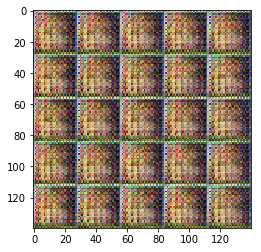

Epoch 1/1... Discriminator Loss: 0.4302... Generator Loss: 3.2085
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 3.2061
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.0206
Epoch 1/1... Discriminator Loss: 0.5461... Generator Loss: 2.6276
Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.8544
Epoch 1/1... Discriminator Loss: 0.4228... Generator Loss: 3.2169
Epoch 1/1... Discriminator Loss: 0.4934... Generator Loss: 2.3770
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 2.7037
Epoch 1/1... Discriminator Loss: 0.5959... Generator Loss: 2.8224


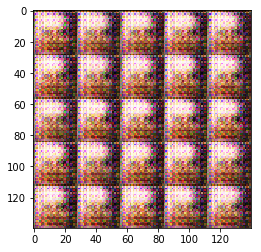

Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 2.8055
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 2.6228
Epoch 1/1... Discriminator Loss: 0.3829... Generator Loss: 4.8005
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 2.7005
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 2.0547
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 3.0539
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 3.2031
Epoch 1/1... Discriminator Loss: 0.4433... Generator Loss: 2.7695
Epoch 1/1... Discriminator Loss: 0.4177... Generator Loss: 3.0908
Epoch 1/1... Discriminator Loss: 0.4282... Generator Loss: 3.3329


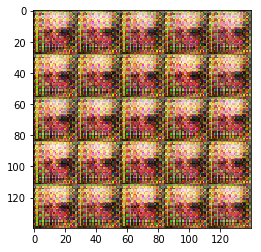

Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.2090
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.3236
Epoch 1/1... Discriminator Loss: 0.4369... Generator Loss: 2.9279
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 3.5429
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 3.5684
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.5572
Epoch 1/1... Discriminator Loss: 0.3812... Generator Loss: 3.5850
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 3.5222
Epoch 1/1... Discriminator Loss: 0.3897... Generator Loss: 4.1519
Epoch 1/1... Discriminator Loss: 0.4267... Generator Loss: 2.8956


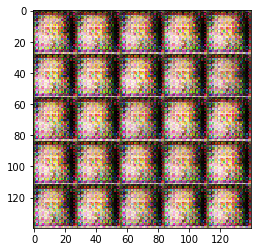

Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 3.1822
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 3.5803
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 3.1335
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.0004
Epoch 1/1... Discriminator Loss: 0.4793... Generator Loss: 2.8946
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.4883
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 3.0158
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 4.6073
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.0235


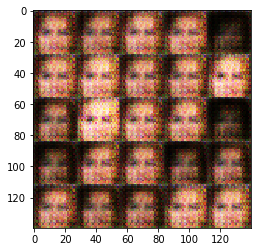

Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.4449
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.9411
Epoch 1/1... Discriminator Loss: 0.5767... Generator Loss: 2.3868
Epoch 1/1... Discriminator Loss: 0.8957... Generator Loss: 1.4728
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 2.6909
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.3058
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 2.7464
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 1.7340
Epoch 1/1... Discriminator Loss: 0.9898... Generator Loss: 1.4280


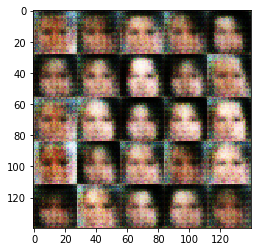

Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 2.1214
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9429
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.7064
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.6864
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.4709
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 2.1839
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.0380


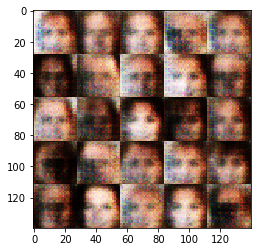

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.1104


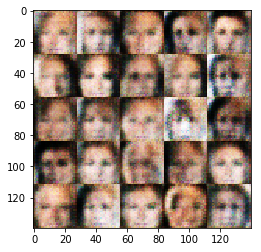

Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0267


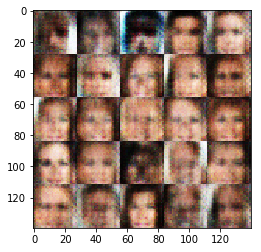

Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.4328
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 2.1817
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 1.5469
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7506


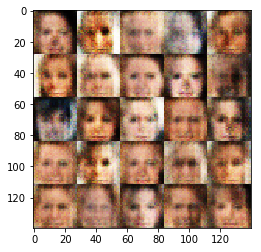

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.5239
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 1.0252


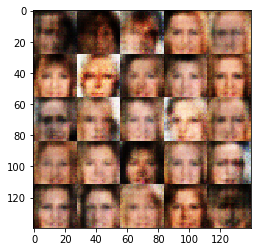

Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.0319


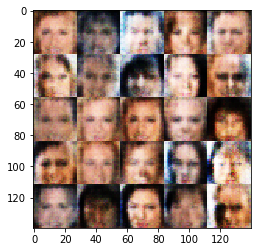

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.4953
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.7996


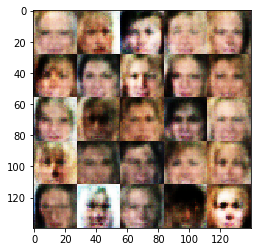

Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.1951... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.5254


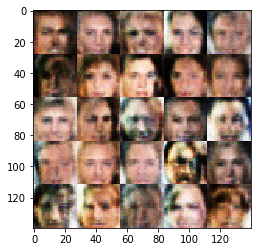

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8655


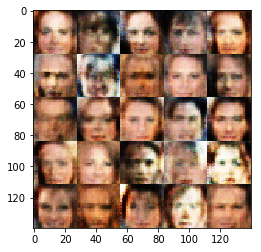

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.1546


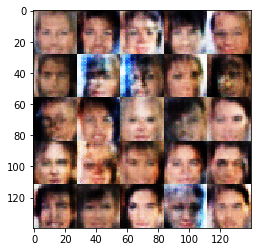

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.9550
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 1.6086
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7474


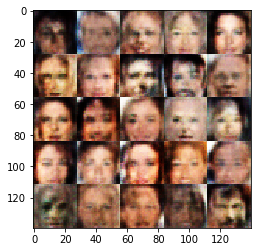

Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 1.7881
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.3924
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6032


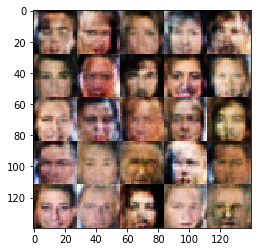

Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6525


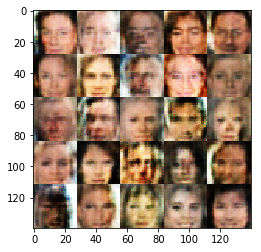

Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.0411
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8842


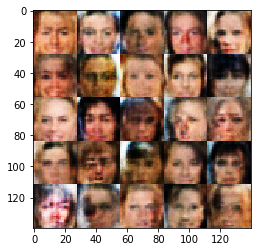

Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 1.0748
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 1.0792


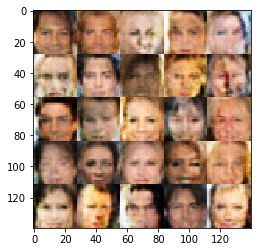

Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.5246


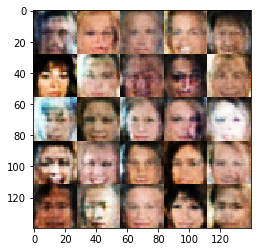

Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.8182


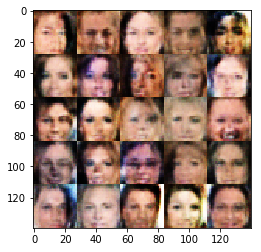

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7765


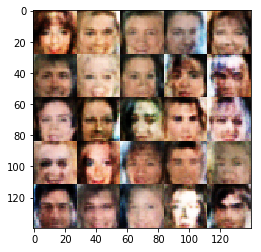

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 1.3181
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.4007
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5432


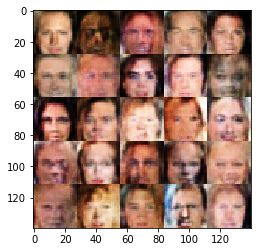

Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.4523
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5067


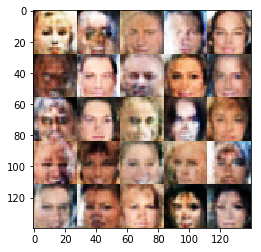

Epoch 1/1... Discriminator Loss: 1.5737... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.5900


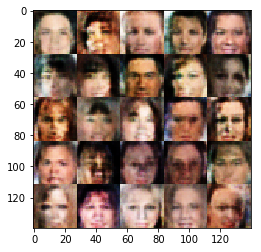

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.7531


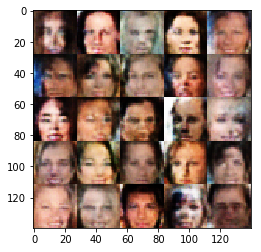

Epoch 1/1... Discriminator Loss: 1.0683... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 1.3109
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7915


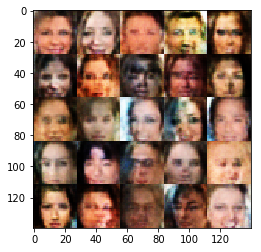

Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7137


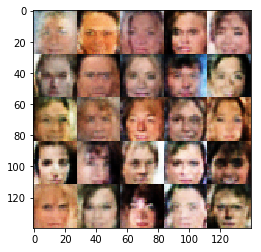

Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.5596


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.